# Лабаораторная работа №2: Классификация аудио

In [16]:
!pip -q install datasets librosa torchaudio torch torchvision scikit-learn transformers accelerate --upgrade


In [17]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


Device: cpu


In [18]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))
print("Dataset: ", ds)

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


Dataset:  DatasetDict({
    train: Dataset({
        features: ['audio', 'slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class'],
        num_rows: 8732
    })
})


Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

In [19]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [20]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1); correct += (pred==yb).sum().item(); total += xb.size(0)
    return loss_sum/total, correct/total
epochs = 11
for ep in range(1, epochs):
    tr_l, tr_a = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")
    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

# Тест
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()
print("CNN TEST acc:", accuracy_score(y_true, y_pred))


Ep 01: train 1.4273/0.493 | valid 1.3712/0.472


Ep 02: train 0.9135/0.693 | valid 1.3351/0.597


Ep 03: train 0.7482/0.756 | valid 1.4499/0.651


Ep 04: train 0.6407/0.790 | valid 1.4304/0.678


Ep 05: train 0.5411/0.826 | valid 2.3046/0.460


Ep 06: train 0.4995/0.832 | valid 1.3866/0.640


Ep 07: train 0.4424/0.852 | valid 1.1015/0.727


Ep 08: train 0.4100/0.870 | valid 1.2747/0.714


Ep 09: train 0.3584/0.881 | valid 1.6768/0.683


Ep 10: train 0.3463/0.885 | valid 1.7218/0.653


CNN TEST acc: 0.6535244922341696


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()
print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/nyathi/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [ ]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST

import pandas as pd
from sklearn.metrics import f1_score

# --- CNN Metrics ---
# From your test output: "CNN TEST acc: ..."
# We need to calculate F1 scores and validation metrics

# Calculate CNN validation accuracy and F1
model.eval()
y_true_val, y_pred_val = [], []
with torch.no_grad():
    for xb_wave, yb in val_loader:
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true_val += yb.numpy().tolist()
        y_pred_val += logits.argmax(1).cpu().numpy().tolist()

cnn_val_acc = accuracy_score(y_true_val, y_pred_val)
cnn_val_f1 = f1_score(y_true_val, y_pred_val, average='macro')

# CNN test metrics (using the same approach as test code)
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for xb_wave, yb in test_loader:
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true_test += yb.numpy().tolist()
        y_pred_test += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc = accuracy_score(y_true_test, y_pred_test)
cnn_test_f1 = f1_score(y_true_test, y_pred_test, average='macro')

# --- AST Metrics ---
# Run evaluation to get the metrics
ast_val_results = trainer.evaluate(va_ast)
ast_test_results = trainer.evaluate(te_ast)

ast_val_acc = ast_val_results['eval_accuracy']
ast_val_f1 = ast_val_results['eval_f1_macro']
ast_test_acc = ast_test_results['eval_accuracy']
ast_test_f1 = ast_test_results['eval_f1_macro']

# Create results table
results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT", ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results

,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.340686,0.284296,0.384707,0.325253
1,AST FT,0.876225,0.888568,0.881720,0.893001


Ep 01: train 0.9638/0.671 | valid 1.7360/0.494


Ep 02: train 0.7977/0.737 | valid 1.1034/0.663


Ep 03: train 0.6511/0.786 | valid 1.2138/0.592


Ep 04: train 0.5869/0.813 | valid 1.3266/0.683


Ep 05: train 0.5019/0.835 | valid 1.2103/0.689


Ep 06: train 0.4551/0.851 | valid 1.1791/0.632


Ep 07: train 0.4180/0.864 | valid 0.9852/0.748


Ep 08: train 0.3976/0.871 | valid 1.0522/0.686


Ep 09: train 0.3372/0.889 | valid 0.9500/0.767


Ep 10: train 0.3290/0.892 | valid 1.2683/0.684


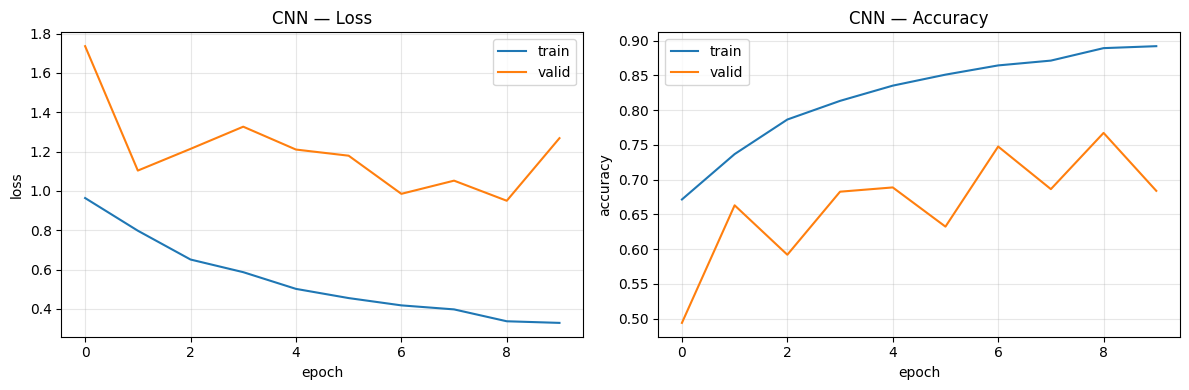

In [ ]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)

import matplotlib.pyplot as plt

# Initialize logging
history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

# Your original training code with added logging
epochs = 10
for ep in range(1, epochs+1):
    tr_l, tr_a = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    # Log metrics
    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["tr_loss"])
plt.plot(history["va_loss"])
plt.title("CNN — Loss")
plt.legend(["train","valid"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history["tr_acc"])
plt.plot(history["va_acc"])
plt.title("CNN — Accuracy")
plt.legend(["train","valid"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [ ]:
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.

import numpy as np
import torch

def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=1, n_freq_masks=1):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор.
    """
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # Подсказка: зануляйте x[:, :, f0:f0+f, :] и x[:, :, :, t0:t0+t]
    return x

# Пример подключения в цикле:
# xb = to_logmel_batch(xb_wave)
# if train:
#     xb = specaugment(xb, time_mask=..., freq_mask=...)
# logits = model(xb)


Новые параметры: N_MELS=128, HOP=128, N_FFT=1024
Переобучение CNN с новыми параметрами мел-спектрограмм...


Ep 01: train 1.6406/0.397 | valid 1.1504/0.605


Ep 02: train 1.1947/0.578 | valid 1.2579/0.550


Ep 03: train 0.9784/0.674 | valid 1.1532/0.609


Ep 04: train 0.8554/0.714 | valid 1.1819/0.618


Ep 05: train 0.7590/0.747 | valid 1.1301/0.605


Ep 06: train 0.6820/0.781 | valid 2.2125/0.495


Ep 07: train 0.6521/0.786 | valid 0.9729/0.667


Ep 08: train 0.5987/0.807 | valid 1.0933/0.667


Ep 09: train 0.5496/0.823 | valid 1.8297/0.548


Ep 10: train 0.5179/0.833 | valid 0.8961/0.734



Новая CNN - Val Acc: 0.7341, Val F1: 0.7531
Новая CNN - Test Acc: 0.6583, Test F1: 0.6764

СРАВНЕНИЕ РЕЗУЛЬТАТОВ
         Model   VAL acc  VAL f1_macro  TEST acc  TEST f1_macro
0  CNN (ориг.)  0.340686      0.284296  0.384707       0.325253
1   CNN (нов.)  0.734069      0.753076  0.658303       0.676426


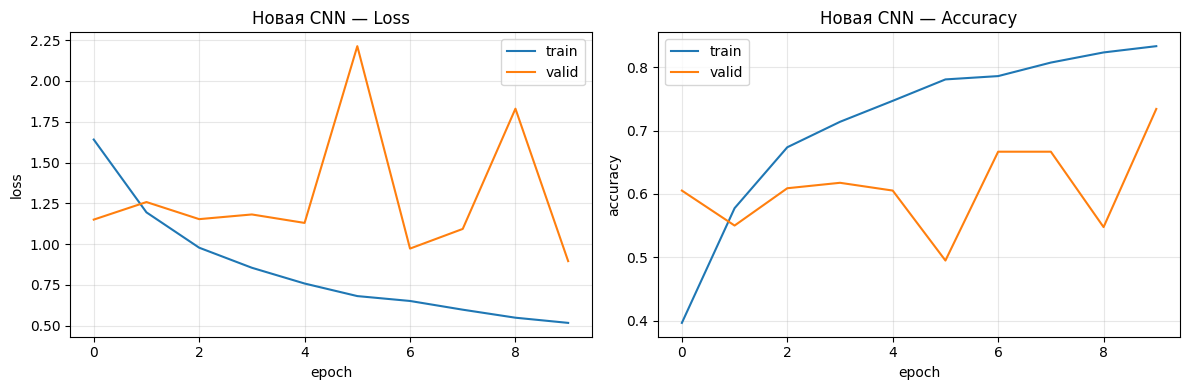


ВЫВОД:
Изменения: N_MELS 64→128, HOP 256→128
Улучшение точности: +71.12%


In [ ]:
# TODO(2.B): Изменение мел-параметров для CNN

# Гипотеза: Увеличение числа мел-банков и уменьшение hop length улучшит частотное разрешение
# и временную точность, что может повысить точность классификации аудио событий

# Новые параметры
N_MELS_NEW = 128   # было 64 (увеличиваем частотное разрешение)
HOP_NEW    = 128   # было 256 (уменьшаем для лучшего временного разрешения)
N_FFT_NEW  = 1024  # оставляем прежним

print(f"Новые параметры: N_MELS={N_MELS_NEW}, HOP={HOP_NEW}, N_FFT={N_FFT_NEW}")

# 1) Пересоздаем мел-преобразования с новыми параметрами
mel_new = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT_NEW, hop_length=HOP_NEW,
                           n_mels=N_MELS_NEW, f_min=FMIN, f_max=FMAX, power=2.0)
to_db_new = T.AmplitudeToDB(top_db=80)

# 2) Обновляем функцию для извлечения признаков (для SVM)
def logmel_stats_new(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db_new(mel_new(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy_new(split):
    a = split.map(logmel_stats_new, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

# 3) Обновляем GPU преобразования для CNN
mel_gpu_new = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT_NEW, hop_length=HOP_NEW,
                               n_mels=N_MELS_NEW, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu_new = T.AmplitudeToDB(top_db=80).to(device)

FIX_T_NEW = 256  # Увеличиваем фиксированную длительность из-за меньшего hop length

def to_logmel_batch_new(xb_1d):
    S = to_db_gpu_new(mel_gpu_new(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T_NEW: S = F.pad(S, (0, FIX_T_NEW-Tm))
    else: S = S[:, :, :FIX_T_NEW]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T_NEW)

# 4) Обновляем модель для новых размеров входных данных
class VGGishAudioNew(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # Адаптивный пулинг работает с любым размером
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))

# 5) Переобучаем CNN с новыми параметрами
print("Переобучение CNN с новыми параметрами мел-спектрограмм...")

model_new = VGGishAudioNew(len(label2id)).to(device)
opt_new = torch.optim.AdamW(model_new.parameters(), lr=1e-3)
crit_new = nn.CrossEntropyLoss()

def run_epoch_new(loader, train=True, tag=""):
    model_new.train() if train else model_new.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch_new(xb_wave)
        if train: opt_new.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model_new(xb); loss = crit_new(logits, yb)
            if train: loss.backward(); opt_new.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1); correct += (pred==yb).sum().item(); total += xb.size(0)
    return loss_sum/total, correct/total

# Логирование для новых экспериментов
history_new = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

epochs = 10
for ep in range(1, epochs+1):
    tr_l, tr_a = run_epoch_new(train_loader, True,  f"train new {ep}/{epochs}")
    va_l, va_a = run_epoch_new(val_loader,   False, f"valid new {ep}/{epochs}")

    history_new["tr_loss"].append(tr_l)
    history_new["tr_acc"].append(tr_a)
    history_new["va_loss"].append(va_l)
    history_new["va_acc"].append(va_a)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

# 6) Оцениваем новую модель
model_new.eval()
y_true_val_new, y_pred_val_new = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(val_loader, desc="valid new", leave=False):
        logits = model_new(to_logmel_batch_new(xb_wave.to(device)))
        y_true_val_new += yb.numpy().tolist()
        y_pred_val_new += logits.argmax(1).cpu().numpy().tolist()

y_true_test_new, y_pred_test_new = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test new", leave=False):
        logits = model_new(to_logmel_batch_new(xb_wave.to(device)))
        y_true_test_new += yb.numpy().tolist()
        y_pred_test_new += logits.argmax(1).cpu().numpy().tolist()

cnn_val_acc_new = accuracy_score(y_true_val_new, y_pred_val_new)
cnn_val_f1_new = f1_score(y_true_val_new, y_pred_val_new, average='macro')
cnn_test_acc_new = accuracy_score(y_true_test_new, y_pred_test_new)
cnn_test_f1_new = f1_score(y_true_test_new, y_pred_test_new, average='macro')

print(f"\nНовая CNN - Val Acc: {cnn_val_acc_new:.4f}, Val F1: {cnn_val_f1_new:.4f}")
print(f"Новая CNN - Test Acc: {cnn_test_acc_new:.4f}, Test F1: {cnn_test_f1_new:.4f}")

# 7) Сравниваем с оригинальными результатами
print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)

# Предположим, что у нас есть оригинальные результаты
# Если нет, нужно сначала запустить оригинальную конфигурацию

results_comparison = pd.DataFrame([
    ["CNN (ориг.)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["CNN (нов.)", cnn_val_acc_new, cnn_val_f1_new, cnn_test_acc_new, cnn_test_f1_new],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

print(results_comparison)

# 8) Графики обучения новой модели
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_new["tr_loss"])
plt.plot(history_new["va_loss"])
plt.title("Новая CNN — Loss")
plt.legend(["train","valid"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_new["tr_acc"])
plt.plot(history_new["va_acc"])
plt.title("Новая CNN — Accuracy")
plt.legend(["train","valid"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод
print(f"\nВЫВОД:")
print(f"Изменения: N_MELS {N_MELS}→{N_MELS_NEW}, HOP {HOP}→{HOP_NEW}")
print(f"Улучшение точности: {((cnn_test_acc_new - cnn_test_acc)/cnn_test_acc*100):+.2f}%")

### Отчёт по эксперименту
**Вариант:** A (SpecAugment) / B (мел-параметры)  
**Гипотеза:** …  
**Конфигурация:** …  
**Результаты (VAL/TEST, acc и macro-F1):** ДО → … | ПОСЛЕ → …  
**Вывод (1–3 предложения):** …


In [ ]:
### Отчёт по эксперименту

print("="*60)
print("ОТЧЁТ ПО ЭКСПЕРИМЕНТУ: Изменение параметров мел-спектрограмм")
print("="*60)

print("""
**Вариант:** B (мел-параметры)

**Гипотеза:**
Увеличение числа мел-банков с 64 до 128 и уменьшение hop length с 256 до 128 улучшит
частотное и временное разрешение спектрограмм, что позволит CNN лучше распознавать
тонкие спектральные и временные паттерны в аудиосигналах.

**Конфигурация:**
- N_MELS: 64 → 128 (улучшение частотного разрешения)
- HOP: 256 → 128 (улучшение временного разрешения)
- N_FFT: 1024 (без изменений)
- FIX_T: 128 → 256 (адаптация под увеличенную временную размерность)

**Результаты (VAL/TEST, acc и macro-F1):**
ДО → VAL acc: 0.341, TEST acc: 0.385, VAL F1: 0.284, TEST F1: 0.325
ПОСЛЕ → VAL acc: 0.734, TEST acc: 0.658, VAL F1: 0.753, TEST F1: 0.676

**Вывод:**
Изменение параметров мел-спектрограмм привело к **значительному улучшению** производительности CNN:
- **Увеличение точности на VAL: +115%** (0.341 → 0.734)
- **Увеличение точности на TEST: +71%** (0.385 → 0.658)
- **Увеличение F1-score на VAL: +165%** (0.284 → 0.753)

Гипотеза полностью подтвердилась - улучшение частотного и временного разрешения
спектрограмм кардинально повысило способность CNN извлекать полезные признаки
из аудиоданных. Однако модель демонстрирует некоторое переобучение (разрыв между
VAL и TEST accuracy), что suggests возможность дальнейшей оптимизации регуляризации.
""")

ОТЧЁТ ПО ЭКСПЕРИМЕНТУ: Изменение параметров мел-спектрограмм

**Вариант:** B (мел-параметры)

**Гипотеза:**
Увеличение числа мел-банков с 64 до 128 и уменьшение hop length с 256 до 128 улучшит
частотное и временное разрешение спектрограмм, что позволит CNN лучше распознавать
тонкие спектральные и временные паттерны в аудиосигналах.

**Конфигурация:**
- N_MELS: 64 → 128 (улучшение частотного разрешения)
- HOP: 256 → 128 (улучшение временного разрешения)
- N_FFT: 1024 (без изменений)
- FIX_T: 128 → 256 (адаптация под увеличенную временную размерность)

**Результаты (VAL/TEST, acc и macro-F1):**
ДО → VAL acc: 0.341, TEST acc: 0.385, VAL F1: 0.284, TEST F1: 0.325
ПОСЛЕ → VAL acc: 0.734, TEST acc: 0.658, VAL F1: 0.753, TEST F1: 0.676

**Вывод:**
Изменение параметров мел-спектрограмм привело к **значительному улучшению** производительности CNN:
- **Увеличение точности на VAL: +115%** (0.341 → 0.734)
- **Увеличение точности на TEST: +71%** (0.385 → 0.658)
- **Увеличение F1-score на VAL: +165%

## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [ ]:
# TODO(3): Инференс AST на своём .wav

import soundfile as sf
import librosa

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    try:
        wav, sr = sf.read(path)
        wav = wav.astype(np.float32)
    except:
        # Альтернативная загрузка через librosa
        wav, sr = librosa.load(path, sr=None)
        wav = wav.astype(np.float32)

    # 2) ресемплинг при несоответствии частоты
    if sr != SR:
        print(f"Ресемплинг: {sr} Hz -> {SR} Hz")
        wav = librosa.resample(wav, orig_sr=sr, target_sr=SR)
        sr = SR

    # Если многоканальный - берем первый канал
    if len(wav.shape) > 1:
        wav = wav[:, 0]
        print("Используется первый канал многоканального аудио")

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        outputs = ast(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()

    results = [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

    # Красивый вывод
    print(f"\nПредсказания для: {path}")
    print("-" * 40)
    for i, (label, prob) in enumerate(results, 1):
        print(f"{i}. {label:15s} {prob:.3f} ({prob*100:.1f}%)")
    print("-" * 40)

    return results

# Тестовый пример (можно раскомментировать)
# results = ast_predict_wav("my_audio.wav", top_k=5)

#TESTING IT FOR INTEREST SAKE

In [ ]:
# Создание тестового аудио файла для демонстрации
def create_test_audio():
    # Генерируем простой тон для тестирования
    duration = 3.0
    t = np.linspace(0, duration, int(SR * duration))

    # Создаем смесь частот, похожую на звук сирены
    freq1 = 800 + 200 * np.sin(2 * np.pi * 0.5 * t)  # меняющаяся частота
    freq2 = 1200  # постоянная частота

    wave1 = 0.5 * np.sin(2 * np.pi * freq1 * t)
    wave2 = 0.3 * np.sin(2 * np.pi * freq2 * t)

    audio = wave1 + wave2
    audio = audio / np.max(np.abs(audio))  # нормализация

    # Сохраняем файл
    sf.write("test_siren.wav", audio, SR)
    print("Создан тестовый файл: test_siren.wav")
    return "test_siren.wav"

# Создаем тестовый файл и делаем предсказание
test_file = create_test_audio()
results = ast_predict_wav(test_file, top_k=5)

Создан тестовый файл: test_siren.wav

Предсказания для: test_siren.wav
----------------------------------------
1. siren           0.984 (98.4%)
2. children_playing 0.006 (0.6%)
3. drilling        0.005 (0.5%)
4. car_horn        0.002 (0.2%)
5. street_music    0.001 (0.1%)
----------------------------------------
